In [1]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
expected = pd.read_csv('datasets/kleister_charity/dev-0/expected.tsv', sep='\t', header=None, names=['raw'])

for key_value_pair in expected["raw"]:
    for key_value in key_value_pair.split(" "):
        key, value = key_value.split("=")
        expected.loc[expected["raw"] == key_value_pair, key] = value

# renaming and sorting for better readability
expected.columns = ["raw", "Address (post town)", "Address (post code)", "Charity Name", "Charity Number", "Period End Date", "Address (street)", "Annual Income",  "Annual Spending"]
expected = expected[["raw", "Address (post town)", "Address (post code)", "Address (street)", "Charity Name", "Charity Number", "Period End Date", "Annual Income", "Annual Spending"]]

expected.head()

,raw,Address (post town),Address (post code),Address (street),Charity Name,Charity Number,Period End Date,Annual Income,Annual Spending
0,address__post_town=BROADWAY address__postcode=...,BROADWAY,WR12_7NL,NaN,Wormington_Village_Society,1155074,2018-07-31,NaN,NaN
1,address__post_town=WESTCLIFF-ON-SEA address__p...,WESTCLIFF-ON-SEA,SS0_8HX,47_SECOND_AVENUE,Havens_Christian_Hospice,1022119,2016-03-31,10348000.00,9415000.00
2,address__post_town=CHELTENHAM address__postcod...,CHELTENHAM,GL50_3EP,BAYSHILL_ROAD,Cheltenham_Ladies_College,311722,2016-07-31,32168000.00,27972000.00
3,address__post_town=SHREWSBURY address__postcod...,SHREWSBURY,SY3_7PQ,58_TRINITY_STREET,The_Sanata_Charitable_Trust,1132766,2015-12-31,255653.00,258287.00
4,address__post_town=WARE address__postcode=SG11...,WARE,SG11_2DY,NaN,Cantate_Youth_Choir,1039369,2013-12-31,122836.00,124446.00


In [3]:
# how many values are filled for the different columns (in percent)?
expected.count() / len(expected)

raw                    1.000000
Address (post town)    0.959091
Address (post code)    0.968182
Address (street)       0.886364
Charity Name           1.000000
Charity Number         0.993182
Period End Date        1.000000
Annual Income          0.986364
Annual Spending        0.986364
dtype: float64

In [4]:
predictions = pd.read_csv('datasets/kleister_charity/dev-0/predictions/LLMPipeline(pdf_to_text_model=KleisterCharityWrapper, prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser)_2022-11-24T01-57-18.tsv', sep='\t', header=None, names=['raw'])

for key_value_pair in predictions["raw"]:
    for key_value in key_value_pair.split(" "):
        key, value = key_value.split("=")
        predictions.loc[predictions["raw"] == key_value_pair, key] = value

predictions.columns = ["raw", "Address (post town)", "Address (post code)", "Address (street)", "Charity Name", "Charity Number", "Period End Date", "Annual Income",  "Annual Spending"]

predictions.head()

,raw,Address (post town),Address (post code),Address (street),Charity Name,Charity Number,Period End Date,Annual Income,Annual Spending
0,address__post_town=Wormington address__postcod...,Wormington,WR12_7NL,Dairymead,Wormington_Village_Society,1155074,2018-07-31,NaN,NaN
1,address__post_town=Westcliff-on-Sea address__p...,Westcliff-on-Sea,SS0_8HX,Stuart_House,Havens_Hospices,1057359,2016-03-31,510348000.00,5882000.00
2,address__post_town=London address__postcode=GL...,London,GL50_3EP,Bayshill_Road,Cheltenham_Ladies'_College,311722,2016-07-31,21369852.00,20344530.00
3,charity_name=The_Sanata_Charitable_Trust chari...,NaN,NaN,NaN,The_Sanata_Charitable_Trust,1132766,2015-12-31,22449.00,2408.00
4,address__post_town=Ware address__postcode=SG11...,Ware,SG11_2DY,"Unit_5,_Hadham_Industrial_Estates_Ltd",Cantate_Youth_Choir,1127772,2013-12-31,127292.00,57899.00


In [42]:
log_file = open("../logs/davinci_default_run.log", "r")
log_lines = log_file.readlines() # this ignores empty lines

In [45]:
removed_lines = 0

for line in log_lines:
    if "parse_model_output" in line or not (line.startswith("20")): # 2022, 2023, etc.
        removed_lines += 1
        log_lines.remove(line)


print(f"Log has {len(log_lines)} lines after cleaning")
print(f"Removed lines: {removed_lines}")

Log has 15669 lines after cleaning
Removed lines: 6220


In [7]:
prediction_info = []
empty_key_dict = {
    "Address (post town)": None,
    "Address (post code)": None,
    "Address (street)": None,
    "Charity Name": None,
    "Charity Number": None,
    "Annual Income": None,
    "Period End Date": None,
    "Annual Spending": None,
}

for line in log_lines:
    if "Predicting document" in line: # this is the beginning of a prediction
        # create a new dictionary for this document
        prediction_info.append({
            "num_subdocs": None,
            "num_unifications": 0,
            "collision_per_key": empty_key_dict.copy(),
            "full_collision_per_key": empty_key_dict.copy(),
            "num_unified_values_per_key": empty_key_dict.copy(),
            "correct_in_any_subdoc_per_key": empty_key_dict.copy(),
            "collision_percentage": None,
            "full_collision_percentage": None,
            "correct_in_any_subdoc_percentage": None,
        })

    elif "Final prediction for document" in line: # this is the end of a prediction
        # calculate the percentages
        prediction_info[-1]["collision_percentage"] = np.mean([x for x in prediction_info[-1]["collision_per_key"].values() if x is not None])
        prediction_info[-1]["full_collision_percentage"] = np.mean([x for x in prediction_info[-1]["full_collision_per_key"].values() if x is not None])
        prediction_info[-1]["correct_in_any_subdoc_percentage"] = np.mean([x for x in prediction_info[-1]["correct_in_any_subdoc_per_key"].values() if x is not None])
 
    elif "No subdocs necessary" in line:
        prediction_info[-1]["num_subdocs"] = 1

    elif "Split document into" in line:
        num_subdocs = int(re.search("into (\d+) subdocuments", line).group(1))
        prediction_info[-1]["num_subdocs"] = num_subdocs

    elif "Unification necessary for key" in line:
        key = re.search("Unification necessary for key (.*)", line).group(1)
        prediction_info[-1]["collision_per_key"][key] = False
        prediction_info[-1]["full_collision_per_key"][key] = False
        values = re.search("Unifying \d+ \(lowered\) values (.*)", log_lines[log_lines.index(line)+1]).group(1)

        # values is the string representation of a list, so we can use eval to turn it into a list
        values = eval(values)
        unified_values = int(re.search("Unifying (\d+) \(lowered\) values", log_lines[log_lines.index(line)+1]).group(1))

        assert unified_values == len(values) # sanity check

        # if there is more than 1 value, then it's a unification
        if len(values) > 1:
            prediction_info[-1]["num_unifications"] += 1

            # if there are more than 1 different values, then it's a collision
            if len(set(values)) > 1:
                prediction_info[-1]["collision_per_key"][key] = True

            # if the length of the set is equal to the length of the list, then it's a full collision
            if len(set(values)) == len(values):
                prediction_info[-1]["full_collision_per_key"][key] = True

        if unified_values == 1: # not a unification
            prediction_info[-1]["num_unified_values_per_key"][key] = 0
        else:
            prediction_info[-1]["num_unified_values_per_key"][key] = unified_values


        # which document are we in?
        doc_num = len(prediction_info) - 1

        # get the correct value for this key
        correct_value = expected.iloc[doc_num][key]

        # if it's NaN, then we can't check if it's correct
        if pd.isna(correct_value):
            continue

        # we have to transform the values in the list to the same format as the correct value
        values = [x.replace(" ", "_").replace(":", "_") for x in values]

        # also transform the correct value to lowercase
        correct_value = str(correct_value).lower()

        # if the correct value is in the list of values, then it's correct in at least one subdoc
        if correct_value in values:
            prediction_info[-1]["correct_in_any_subdoc_per_key"][key] = True

        else:
            prediction_info[-1]["correct_in_any_subdoc_per_key"][key] = False

prediction_stats = pd.DataFrame(prediction_info)
prediction_stats.head()

/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,num_subdocs,num_unifications,collision_per_key,full_collision_per_key,num_unified_values_per_key,correct_in_any_subdoc_per_key,collision_percentage,full_collision_percentage,correct_in_any_subdoc_percentage
0,1,0,"{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...",NaN,NaN,NaN
1,9,8,"{'Address (post town)': True, 'Address (post c...","{'Address (post town)': True, 'Address (post c...","{'Address (post town)': 4, 'Address (post code...","{'Address (post town)': True, 'Address (post c...",1.000,0.75,0.500000
2,8,8,"{'Address (post town)': True, 'Address (post c...","{'Address (post town)': False, 'Address (post ...","{'Address (post town)': 5, 'Address (post code...","{'Address (post town)': True, 'Address (post c...",1.000,0.50,0.625000
3,2,2,"{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...",0.400,0.40,0.600000
4,3,8,"{'Address (post town)': True, 'Address (post c...","{'Address (post town)': True, 'Address (post c...","{'Address (post town)': 2, 'Address (post code...","{'Address (post town)': True, 'Address (post c...",0.875,0.75,0.571429


Note: "correct_in_any_subdoc_percentage" assumes that *something* has been found in any of the subdocs. It does not consider the situation where there are no subdocs, or where the value for the key is not found in any of the subdocs.

In [8]:
print("Correct value found in any subdoc percentage:", round(prediction_stats["correct_in_any_subdoc_percentage"].mean(), 2))

# a single entry is a dictionary with the correctness for each key (True, False, or None)
correctness_per_key = prediction_stats["correct_in_any_subdoc_per_key"].tolist()

print("Correct value found (in any subdoc) per key:")
for key in correctness_per_key[0].keys():
    correctness = [x[key] for x in correctness_per_key]
    avg_correctness = np.mean([x for x in correctness if x is not None])
    print(f"{key}: {round(avg_correctness, 2)}")

Correct value found in any subdoc percentage: 0.57
Correct value found (in any subdoc) per key:
Address (post town): 0.71
Address (post code): 0.56
Address (street): 0.34
Charity Name: 0.62
Charity Number: 0.79
Annual Income: 0.25
Period End Date: 0.96
Annual Spending: 0.28


In [9]:
# actually correct value found after unification
# consider only the documents that have more than 1 subdoc
df = prediction_stats[prediction_stats["num_subdocs"] > 1]



In [10]:
# add column "no_collision_percentage" which is the percentage of keys that had no collision
df["no_collision_percentage"] = 1 - df["collision_percentage"]

for i, row in df.iterrows():
    num_keys = len([x for x in row["collision_per_key"].values() if x is not None])
    num_no_collisions = len([x for x in row["collision_per_key"].values() if x is False])
    try:
        df.at[i, "no_collision_percentage_calculated"] = num_no_collisions / num_keys
    except ZeroDivisionError:
        df.at[i, "no_collision_percentage_calculated"] = np.nan

assert np.allclose(df["collision_percentage"], 1 - df["no_collision_percentage_calculated"], equal_nan=True) # sanity check

/var/folders/t1/8_xptc456_9bnyk0lkdrjql00000gn/T/ipykernel_12475/3865665799.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["no_collision_percentage"] = 1 - df["collision_percentage"]
/var/folders/t1/8_xptc456_9bnyk0lkdrjql00000gn/T/ipykernel_12475/3865665799.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[i, "no_collision_percentage_calculated"] = num_no_collisions / num_keys


In [11]:
print(f"Number of predictions: {len(df)}")

Number of predictions: 342


In [12]:
print(f"Number of documents that were split into >1 subdocuments: {len(df[df['num_subdocs'] > 1])}")

Number of documents that were split into >1 subdocuments: 342


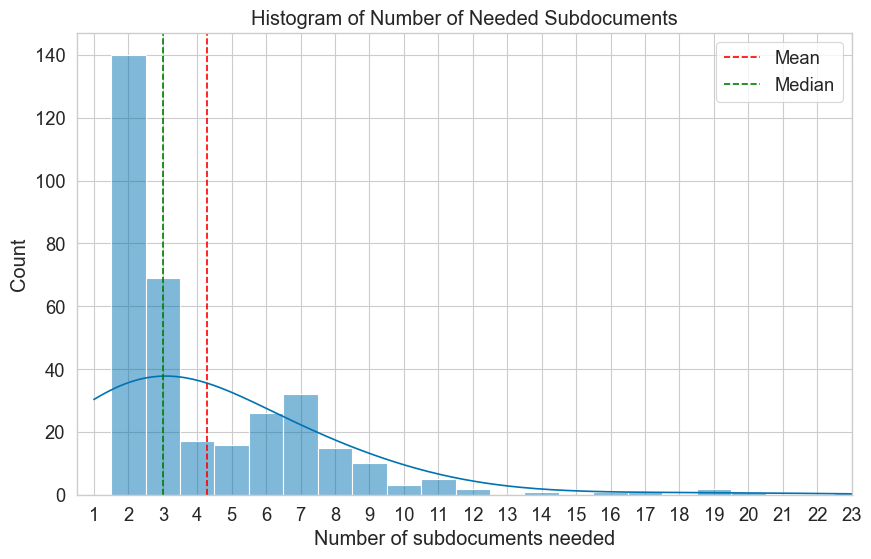

In [13]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(10, 6))

x = df['num_subdocs'].value_counts().sort_index().index
y = df['num_subdocs'].value_counts().sort_index().values

max_subdocs = max(x)

# add a 0 for each number of subdocs up to the maximum number of subdocs, so that there is a value for each number of subdocs
for i in range(1, max_subdocs+1):
    if i not in x:
        x = np.append(x, i)
        y = np.append(y, 0)

sns.histplot(x=x, weights=y, discrete=True, ax=ax, kde=True)

ax.set(xticks=x)
ax.set_xlim(0.5, max_subdocs)

ax.axvline(x=np.average(x, weights=y), color='red', linestyle='--', label="Mean")

# median calculated manually
z = []
for i in range(len(x)):
    z.extend([x[i]] * y[i])

ax.axvline(x=np.median(z), color='green', linestyle='--', label="Median")

ax.set(xlabel="Number of subdocuments needed")
ax.legend()
ax.set_title("Histogram of Number of Needed Subdocuments")

plt.show()
fig.savefig("plots/subdoc_hist.png", dpi=300)


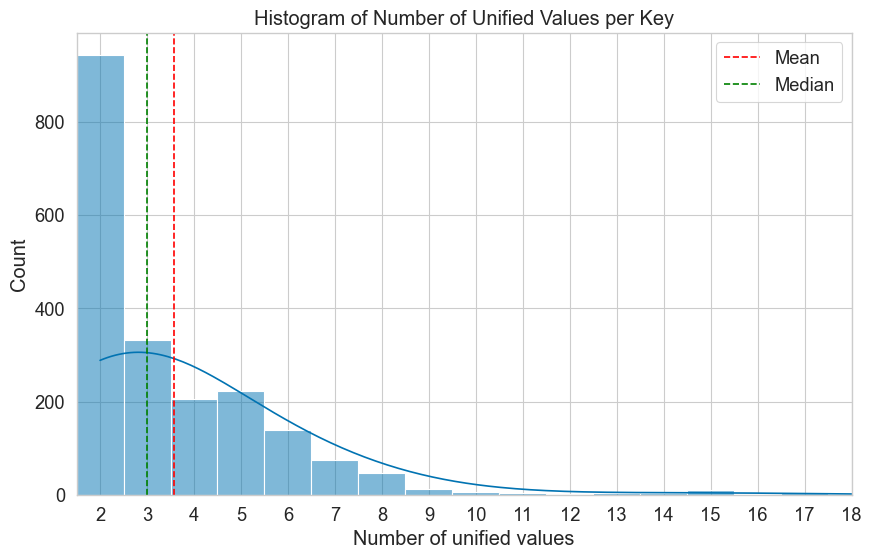

In [14]:
unified_values_per_key = {}

for i in range(len(df)):
    for key, value in df.iloc[i]['num_unified_values_per_key'].items():
        if value is not None and value > 0:
            if key in unified_values_per_key:
                unified_values_per_key[key].append(value)
            else:
                unified_values_per_key[key] = [value]

fig, ax = plt.subplots(figsize=(10, 6))

occurence_dict = {}
for key, values in unified_values_per_key.items():
    for value in values:
        if value in occurence_dict:
            occurence_dict[value] += 1
        else:
            occurence_dict[value] = 1

# intersperse keys that are missing with value 0
for i in range(2, max(occurence_dict.keys())+1):
    if i not in occurence_dict:
        occurence_dict[i] = 0

# sort the dictionary by the key (number of unifications)
occurence_dict = dict(sorted(occurence_dict.items(), key=lambda item: item[0]))

x = list(occurence_dict.keys())
y = list(occurence_dict.values())

sns.histplot(x=x, weights=y, discrete=True, ax=ax, kde=True)

ax.axvline(x=np.average(x, weights=y), color='red', linestyle='--', label="Mean")

# median calculated manually
z = []
for i in range(len(x)):
    z.extend([x[i]] * y[i])

ax.axvline(x=np.median(z), color='green', linestyle='--', label="Median")

ax.set(xticks=x)
ax.set_xlim(1.5, max(x))
ax.set(xlabel="Number of unified values")
ax.set_title("Histogram of Number of Unified Values per Key")
ax.legend()

plt.show()
fig.savefig("plots/unified_values_vs_occurence.png", dpi=300)

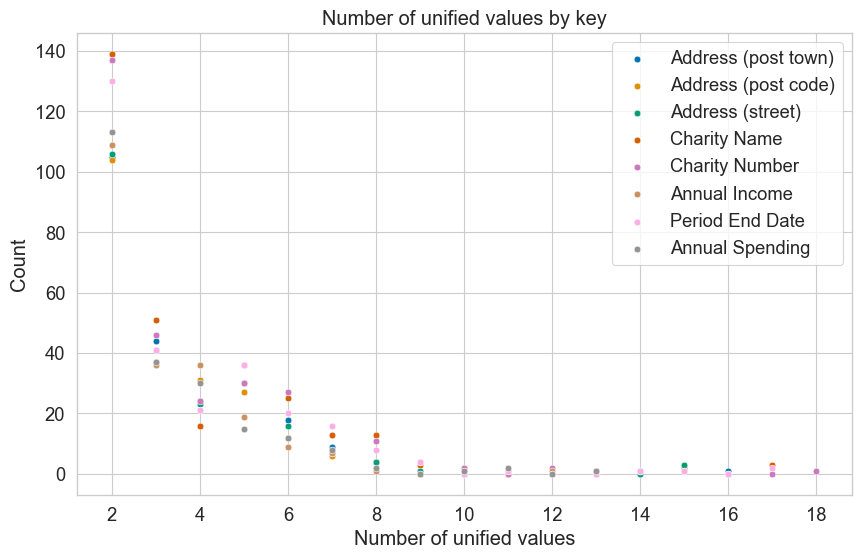

In [15]:
unified_values_per_key = {}

for i in range(len(df)):
    for key, value in df.iloc[i]['num_unified_values_per_key'].items():
        if value is not None and value > 0:
            if key in unified_values_per_key:
                unified_values_per_key[key].append(value)
            else:
                unified_values_per_key[key] = [value]

fig, ax = plt.subplots(figsize=(10, 6))

# one key = one bar plot (histogram)
for key, values in unified_values_per_key.items():
    occurence_dict = {}
    for value in values:
        if value in occurence_dict:
            occurence_dict[value] += 1
        else:
            occurence_dict[value] = 1

    # intersperse keys that are missing with value 0
    for i in range(2, max(occurence_dict.keys())+1):
        if i not in occurence_dict:
            occurence_dict[i] = 0

    # sort the dictionary by the key (number of unifications)
    occurence_dict = dict(sorted(occurence_dict.items(), key=lambda item: item[0]))

    x = list(occurence_dict.keys())
    y = list(occurence_dict.values())

    ax = sns.scatterplot(x=x, y=y, ax=ax, label=key)

ax.set(xlabel="Number of unified values", ylabel="Count")
ax.legend()
ax.set_title("Number of unified values by key")

plt.show()
fig.savefig("plots/unified_values_by_key_vs_count.png", dpi=300)

/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


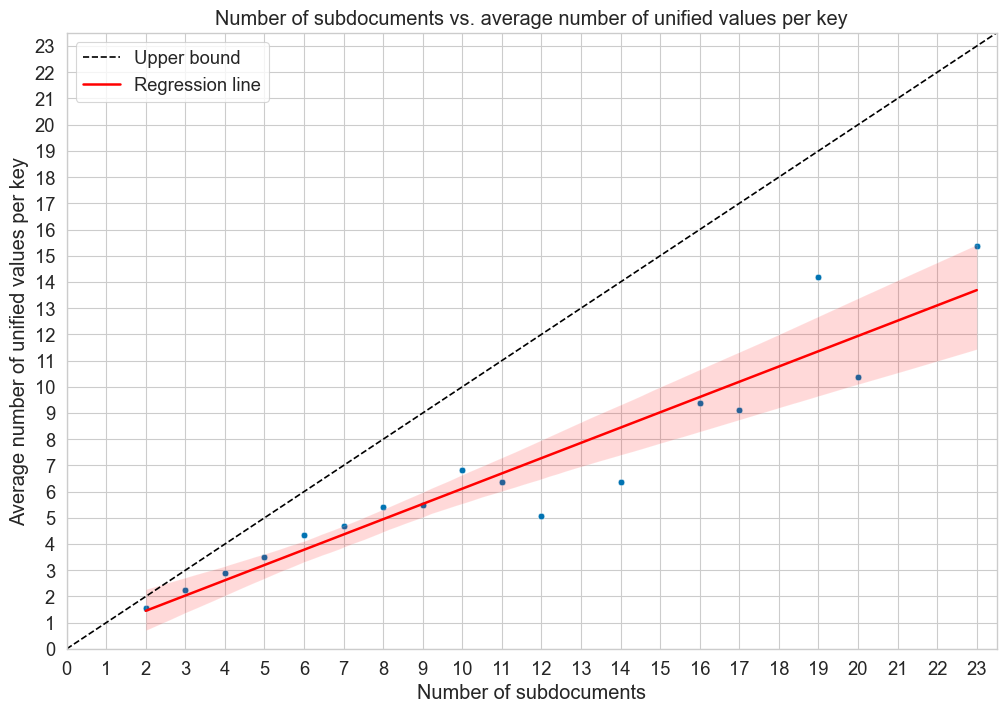

Correlation coefficient: 0.947


In [16]:
fig, ax = plt.subplots(figsize=(12, 8))

max_subdocs = max(df['num_subdocs'])

x = np.arange(0, max_subdocs+1)
y = [] # number of unified values per key (average over all keys)

y = [[] for _ in range(max(x)+1)]

for i in range(len(df)):
    num_subdocs = df.iloc[i]['num_subdocs']
    if num_subdocs == 1:
        continue


    num_unified_values = 0
    num_keys = 0
    for key, value in df.iloc[i]['num_unified_values_per_key'].items():
        if value is not None and value > 0:
            num_unified_values += value
            num_keys += 1
    if num_keys > 0:
        y[num_subdocs].append(num_unified_values / num_keys)
    else:
        y[num_subdocs].append(0)

y = [np.mean(y[i]) for i in range(len(y))] # average number of unified values per key for each number of subdocuments

ax.plot([0, max(x) + 1], [0, max(x) + 1], color='black', linestyle='--', label='Upper bound')

ax = sns.scatterplot(x=x, y=y, ax=ax)

sns.regplot(x=x, y=y, ax=ax, scatter=False, color='red', label='Regression line')

ax.set(xticks=x, yticks=x)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xlim(right=max_subdocs+0.5)
ax.set_ylim(top=max_subdocs+0.5)

# remove nan values from x and y
x = [x[i] for i in range(len(x)) if not np.isnan(y[i])]
y = [y[i] for i in range(len(y)) if not np.isnan(y[i])]


ax.set(xlabel="Number of subdocuments", ylabel="Average number of unified values per key")
ax.legend(loc='upper left')
ax.set_title("Number of subdocuments vs. average number of unified values per key")

plt.show()
fig.savefig("plots/num_subdocs_vs_unified_values_per_key.png", dpi=300)

print("Correlation coefficient: " + str(round(np.corrcoef(x, y)[0, 1], 3)))

In [17]:
print(f"Total number of keys that were unified in some way: {sum(df['num_unifications'])}")

x = []
y = []

for key, values in unified_values_per_key.items():
    x.append(key)
    y.append(sum(values)/len(values))

# round to 2 decimal places
y = [round(y[i], 2) for i in range(len(y))]

# create a table with the keys and the average number of unified values per key
key_stats = pd.DataFrame({'key': x, 'avg_num_unified_values': y})

# print the table
print(key_stats)

Total number of keys that were unified in some way: 2015
                   key  avg_num_unified_values
0  Address (post town)                    3.57
1  Address (post code)                    3.46
2     Address (street)                    3.51
3         Charity Name                    3.82
4       Charity Number                    3.70
5        Annual Income                    3.27
6      Period End Date                    3.75
7      Annual Spending                    3.26


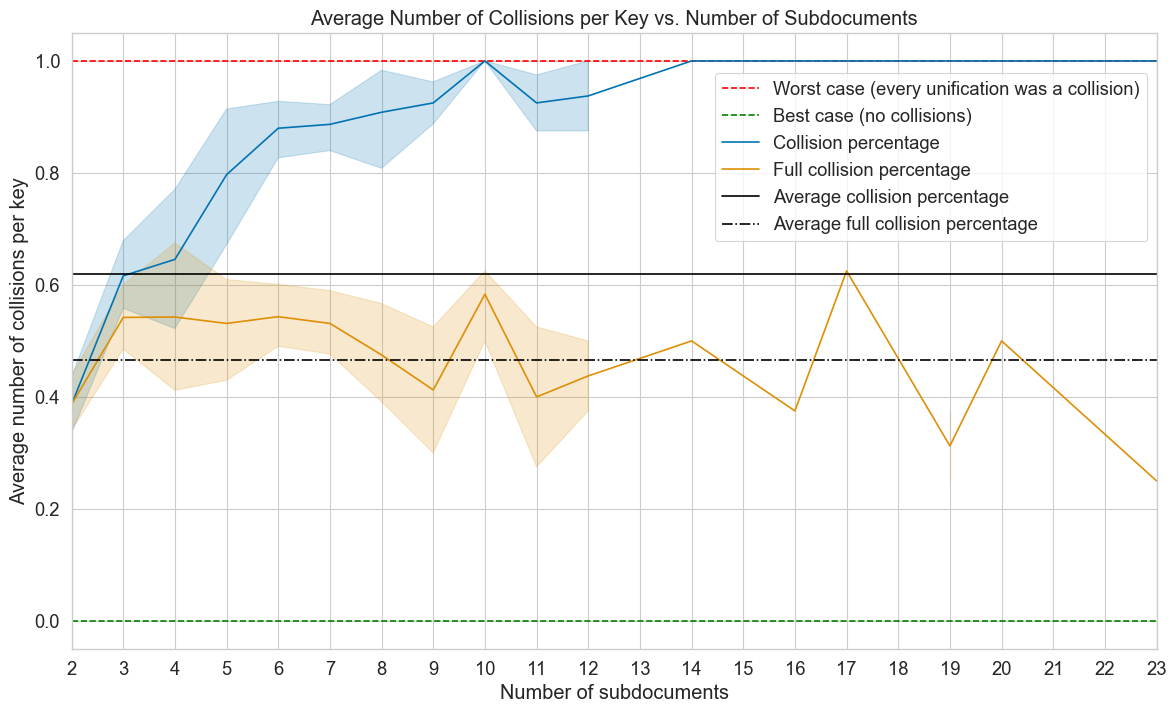

In [18]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(14, 8))

ax.axhline(y=1, color="red", linestyle="--", label="Worst case (every unification was a collision)")
ax.axhline(y=0, color="green", linestyle="--", label="Best case (no collisions)")

ax = sns.lineplot(x="num_subdocs", y="collision_percentage", data=df, ax=ax, label="Collision percentage")
ax = sns.lineplot(x="num_subdocs", y="full_collision_percentage", data=df, ax=ax, label="Full collision percentage")

avg_collision_percentage = np.nanmean(df['collision_percentage'])
ax.axhline(y=avg_collision_percentage, color="black", linestyle="-", label="Average collision percentage")

avg_full_collision_percentage = np.nanmean(df['full_collision_percentage'])
ax.axhline(y=avg_full_collision_percentage, color="black", linestyle="-.", label="Average full collision percentage")

ax.set_xlim(left=2, right=max(df['num_subdocs']))
ax.set(xticks=np.arange(2, max_subdocs+1, 1))
ax.set(xlabel="Number of subdocuments", ylabel="Average number of collisions per key", title="Average Number of Collisions per Key vs. Number of Subdocuments")
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))

plt.show()

fig.savefig("plots/collisions_wrt_subdocs_hist.png", dpi=300)

1 subdocument == no subdocs (or in other words: the 1 subdoc is the whole document)

Note: best case assumes:
* perfect OCR
* no mistakes in the reports (no typos, no conflicting information on different pages)

of course with num_subdocs=2 every collision is a full_collision :) 

In [19]:
key_stats

,key,avg_num_unified_values
0,Address (post town),3.57
1,Address (post code),3.46
2,Address (street),3.51
3,Charity Name,3.82
4,Charity Number,3.70
5,Annual Income,3.27
6,Period End Date,3.75
7,Annual Spending,3.26


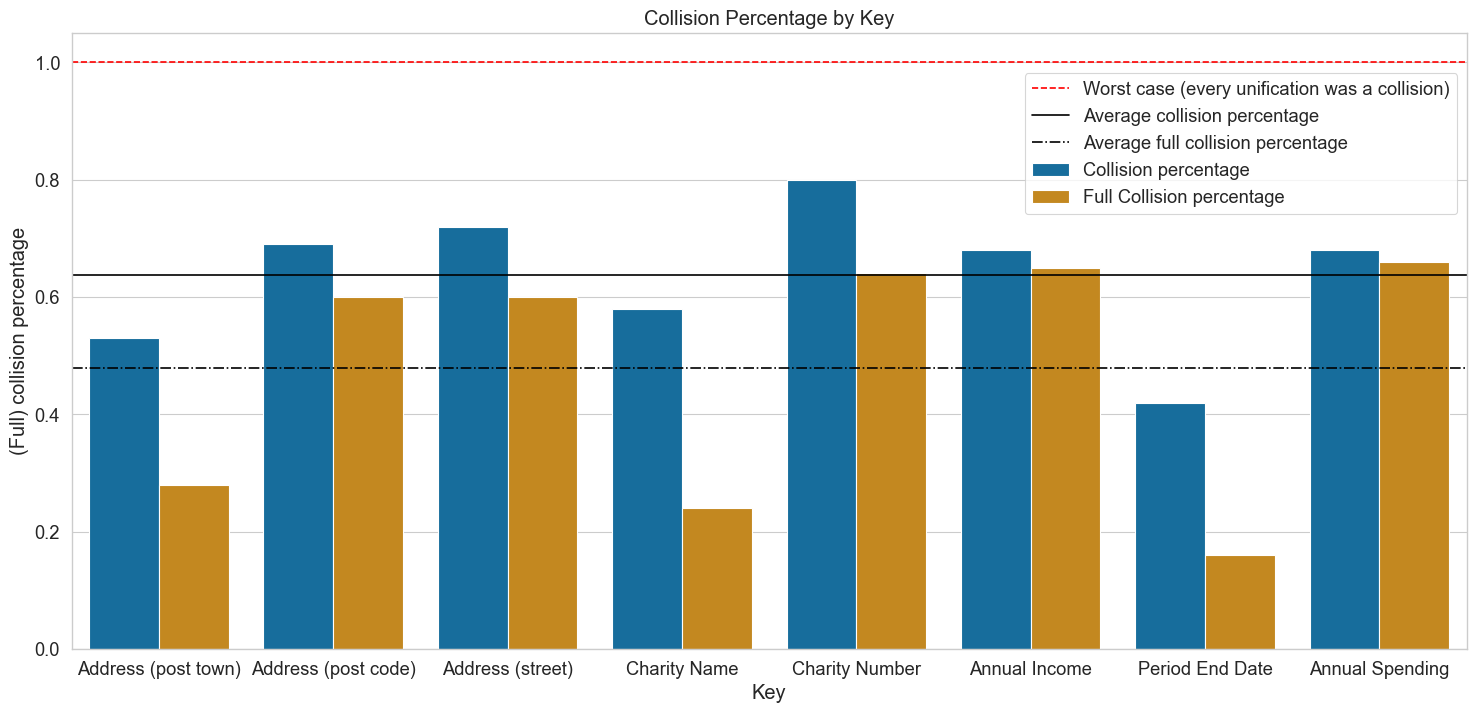

In [20]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(18, 8))

ax.axhline(y=1, color="red", linestyle="--", label="Worst case (every unification was a collision)")

collision_percentage_by_key = {}
full_collision_percentage_by_key = {}

# line plot of the collision percentage by key
for key in df['num_unified_values_per_key'].iloc[0].keys():
    for i in range(len(df)):
        if key not in collision_percentage_by_key:
            collision_percentage_by_key[key] = []

        if key not in full_collision_percentage_by_key:
            full_collision_percentage_by_key[key] = []

        collision_percentage_by_key[key].append(df['collision_per_key'].iloc[i][key])
        full_collision_percentage_by_key[key].append(df['full_collision_per_key'].iloc[i][key])

# filter out None values
collision_percentage_by_key = {key: [x for x in collision_percentage_by_key[key] if x is not None] for key in collision_percentage_by_key.keys()}
full_collision_percentage_by_key = {key: [x for x in full_collision_percentage_by_key[key] if x is not None] for key in full_collision_percentage_by_key.keys()}

# calculate average and ignore nan values and round to 2 decimal places
collision_percentage_by_key = {key: round(np.nanmean(collision_percentage_by_key[key]), 2) for key in collision_percentage_by_key.keys()}
full_collision_percentage_by_key = {key: round(np.nanmean(full_collision_percentage_by_key[key]), 2) for key in full_collision_percentage_by_key.keys()}

# add those values to the dataframe
key_stats['collision_percentage'] = key_stats['key'].map(collision_percentage_by_key)
key_stats['full_collision_percentage'] = key_stats['key'].map(full_collision_percentage_by_key)

# create a barplot that has grouped bars

# we want to use the "hue" parameter to group the bars by collision vs. full collision
# thus we have to transform the dataframe to have a column for each of the two types of collisions
# and a column for the key
key_stats_trf = key_stats.melt(id_vars=['key'], value_vars=['collision_percentage', 'full_collision_percentage'], var_name='collision_type', value_name='collision_pct')

# rename the collision types to something more readable
key_stats_trf['collision_type'] = key_stats_trf['collision_type'].map({'collision_percentage': 'Collision percentage', 'full_collision_percentage': 'Full Collision percentage'})

# create the barplot
ax = sns.barplot(x="key", y="collision_pct", hue="collision_type", data=key_stats_trf, ax=ax)



avg_collision_percentage = np.nanmean(list(collision_percentage_by_key.values()))
ax.axhline(y=avg_collision_percentage, color="black", linestyle="-", label="Average collision percentage")

avg_full_collision_percentage = np.nanmean(list(full_collision_percentage_by_key.values()))
ax.axhline(y=avg_full_collision_percentage, color="black", linestyle="-.", label="Average full collision percentage")

ax.set(xlabel="Key", ylabel="(Full) collision percentage", title="Collision Percentage by Key")
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))

plt.show()
fig.savefig("plots/collision_percentage_by_key.png", dpi=300)

In [21]:
key_stats

,key,avg_num_unified_values,collision_percentage,full_collision_percentage
0,Address (post town),3.57,0.53,0.28
1,Address (post code),3.46,0.69,0.60
2,Address (street),3.51,0.72,0.60
3,Charity Name,3.82,0.58,0.24
4,Charity Number,3.70,0.80,0.64
5,Annual Income,3.27,0.68,0.65
6,Period End Date,3.75,0.42,0.16
7,Annual Spending,3.26,0.68,0.66


In [22]:
# calculate the part of collisions that are full collisions
key_stats['full_collision_over_collision'] = round(key_stats['full_collision_percentage'] / key_stats['collision_percentage'], 2)

In [23]:
key_stats

,key,avg_num_unified_values,collision_percentage,full_collision_percentage,full_collision_over_collision
0,Address (post town),3.57,0.53,0.28,0.53
1,Address (post code),3.46,0.69,0.60,0.87
2,Address (street),3.51,0.72,0.60,0.83
3,Charity Name,3.82,0.58,0.24,0.41
4,Charity Number,3.70,0.80,0.64,0.80
5,Annual Income,3.27,0.68,0.65,0.96
6,Period End Date,3.75,0.42,0.16,0.38
7,Annual Spending,3.26,0.68,0.66,0.97


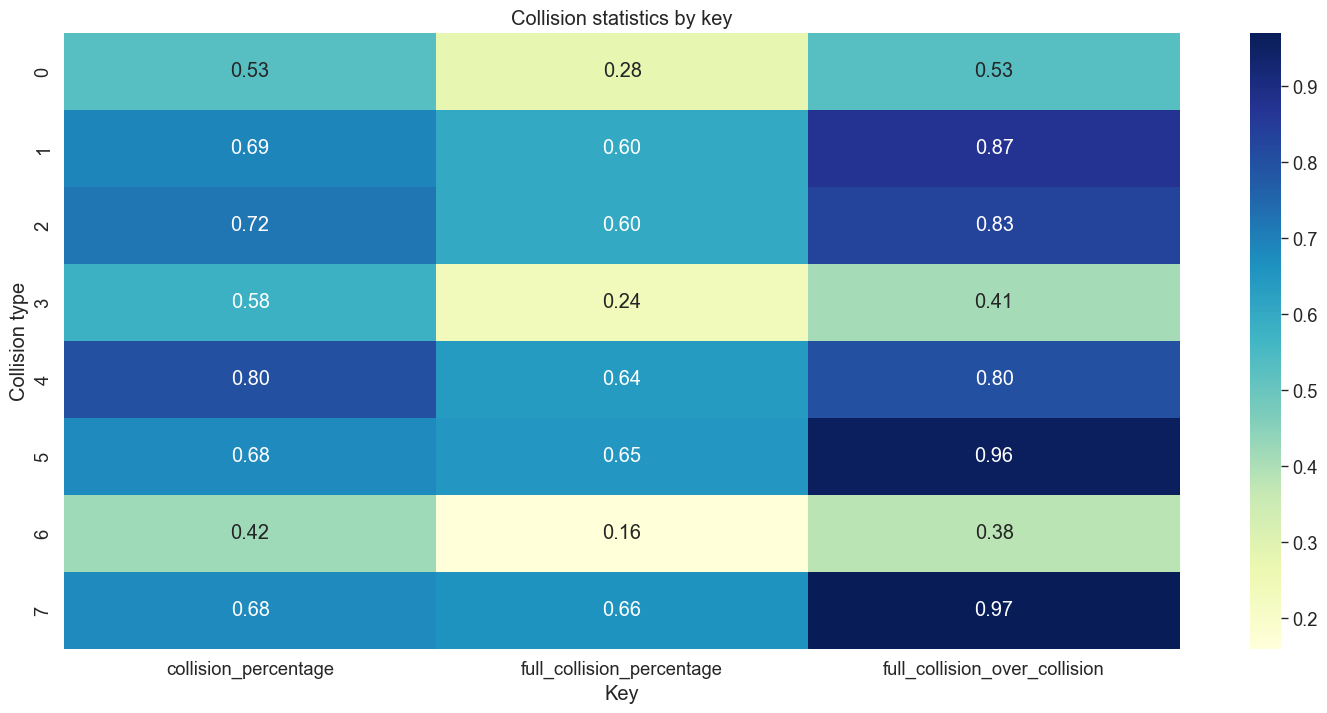

In [24]:
# visualize the dataframe key_stats with a heatmap
fig, ax = plt.subplots(figsize=(18, 8))

# create a heatmap ignore 'key' column
sns.heatmap(key_stats.iloc[:, 2:], annot=True, fmt=".2f", cmap="YlGnBu", ax=ax)

ax.set(xlabel="Key", ylabel="Collision type", title="Collision statistics by key")

plt.show()